In [19]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import json

In [20]:
NAIVE_COLOR: str = "red"
GRAPH_COLOR: str = "blue"
U_ETH_SPACE = [0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128]
U_ETH_SCALE = 1e7
NUMS_OF_TOKENS_SPACE = list(range(3, 13))
COLUMNS_ID = [
    'block_number', 'num_of_tokens', 'u_eth',
    'expected_gas', 'token_in', 'amount_in', 'amount_out', 'return_precost'
]

In [21]:
def json_to_df(json_data):
    flatten_list = []
    for item in json_data:
        item_meta = item.copy()
        del item_meta["arbitrages"]
        for arb in item["arbitrages"]:
            new_item = item_meta.copy()
            new_item.update(arb)
            flatten_list.append(
                new_item
            )
    return pd.DataFrame(flatten_list).drop_duplicates(subset = COLUMNS_ID)

def json_to_meta_df(json_data):
    return pd.DataFrame(json_data)

def make_df(filenames: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_flat = pd.DataFrame()
    df_meta = pd.DataFrame()
    for filename in filenames:
        u_eth_norm = float(filename.split("_")[-1].removesuffix(".json")) * U_ETH_SCALE
        try:
            with open(filename) as f:
                json_data = json.load(f)
                df_flat = pd.concat(
                    [
                        df_flat,
                        json_to_df(json_data).assign(
                            u_eth_norm = lambda df: u_eth_norm
                        ).assign(
                            log_u_eth_norm = lambda df: df["u_eth_norm"].pipe(np.log)
                        )
                    ]
                )
                df_meta = pd.concat(
                    [
                        df_meta,
                        json_to_meta_df(json_data)
                    ]
                )
        except FileNotFoundError:
            continue
    df_flat = df_flat.assign(
        eth_return_precost = lambda df: df["u_eth"].mul(df["return_precost"])
    ).assign(
        log_u_eth = lambda df: df["u_eth"].pipe(np.log)
    )

    return df_meta, df_flat

# Comparison Analysis
Modified graph vs naive

## Runtime Performance
Varying number of tokens

In [22]:
fixed_u_eth = 1
filenames_bf = [
    f"data/bf_test_{num_of_tokens}_{u_eth}.json"
    for num_of_tokens in NUMS_OF_TOKENS_SPACE + list(range(13, 16))
    for u_eth in U_ETH_SPACE
]

filenames_naive = [
    f"data/naive_test_{num_of_tokens}_{fixed_u_eth}.json"
    for num_of_tokens in NUMS_OF_TOKENS_SPACE
]

graph_meta_df, graph_df = make_df(filenames_bf)
naive_meta_df, naive_df = make_df(filenames_naive)

### Lower rate of change

Text(0.5, 1.0, 'Average Runtime (s)')

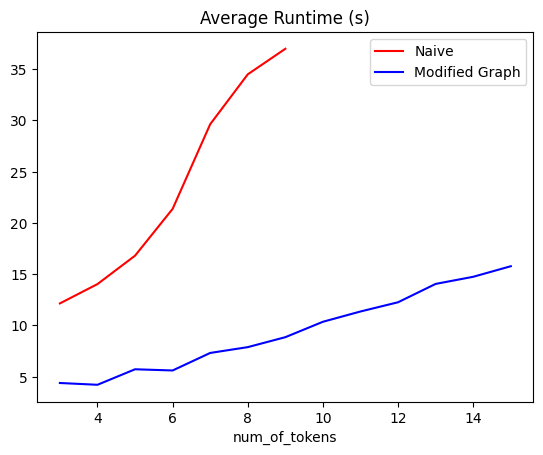

In [23]:
naive_meta_df.groupby(["num_of_tokens"])["time"].mean().plot(color = NAIVE_COLOR)
graph_meta_df.groupby(["num_of_tokens"])["time"].mean().plot(color = GRAPH_COLOR)
plt.legend(["Naive", "Modified Graph"])
plt.title("Average Runtime (s)")

### More consistent

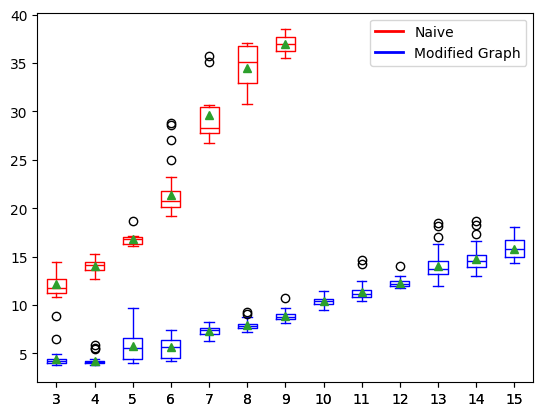

In [24]:
naive_box = naive_meta_df.groupby(["block_number", "num_of_tokens"])["time"].mean().reset_index().pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).assign(
    **{
        str(i): np.nan
        for i in range(10, 16)
    }
).boxplot(color = NAIVE_COLOR, grid = False, showmeans = True)
bf_box = graph_meta_df.groupby(["block_number", "num_of_tokens"])["time"].mean().reset_index().pivot(
    index = "block_number",
    columns = "num_of_tokens",
    values = "time"
).boxplot(color = GRAPH_COLOR, grid = False, showmeans = True)

custom_lines = [Line2D([0], [0], color=NAIVE_COLOR, lw=2),
            Line2D([0], [0], color=GRAPH_COLOR, lw=2)]
plt.legend(custom_lines, ["Naive", "Modified Graph"])

### Fit of Order of Change

In [25]:
naive_time_df = naive_meta_df.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log)
)

OLS(
    naive_time_df["time"],
    naive_time_df["num_of_tokens"].pipe(lambda x: np.power(x, 1))
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   time   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              5570.
Date:                Wed, 03 Apr 2024   Prob (F-statistic):                    9.82e-83
Time:                        15:57:08   Log-Likelihood:                         -221.01
No. Observations:                  91   AIC:                                      444.0
Df Residuals:                      90   BIC:                                      446.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_of_tokens     3.7715      0.051     74.630      0.000       3.671       3.872
==============================================================================
Omnibus:                       29.983   Durbin-Watson:                   0.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.978
Skew:                           1.479   Prob(JB):                     1.04e-10
Kurtosis:                       4.839   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
graph_time_df = graph_meta_df.assign(
    ln_num_of_tokens = lambda df: df["num_of_tokens"].pipe(np.log)
)

OLS(
    graph_time_df["time"],
    graph_time_df["num_of_tokens"].pipe(lambda x: np.power(x, 1))
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   time   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                          4.901e+04
Date:                Wed, 03 Apr 2024   Prob (F-statistic):                        0.00
Time:                        15:57:08   Log-Likelihood:                         -11016.
No. Observations:                4633   AIC:                                  2.203e+04
Df Residuals:                    4632   BIC:                                  2.204e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
num_of_tokens     1.0288      0.005    221.378      0.000       1.020       1.038
==============================================================================
Omnibus:                     2553.786   Durbin-Watson:                   0.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32375.004
Skew:                           2.366   Prob(JB):                         0.00
Kurtosis:                      15.055   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Accuracy and Robustness
Varying U

In [27]:
naive_fixed_num = 6
filenames_bf = [
    f"data/bf_test_{naive_fixed_num}_{u_eth}.json"
    for u_eth in U_ETH_SPACE
]

filenames_naive = [
    f"data/naive_test_{naive_fixed_num}_{u_eth}.json"
    for u_eth in U_ETH_SPACE
]

graph_meta_df, graph_df = make_df(filenames_bf)
naive_meta_df, naive_df = make_df(filenames_naive)

In [28]:
naive_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].count().describe()

count    391.000000
mean       3.943734
std        1.693700
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: eth_return_precost, dtype: float64

In [29]:
graph_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].count().describe()

count    230.000000
mean       1.104348
std        0.320314
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: eth_return_precost, dtype: float64

[Text(1, 0, '14.0'),
 Text(2, 0, '14.7'),
 Text(3, 0, '15.4'),
 Text(4, 0, '16.1'),
 Text(5, 0, '16.8'),
 Text(6, 0, '17.5'),
 Text(7, 0, '18.2'),
 Text(8, 0, '18.9'),
 Text(9, 0, '19.6'),
 Text(10, 0, '20.3'),
 Text(11, 0, '21.0')]

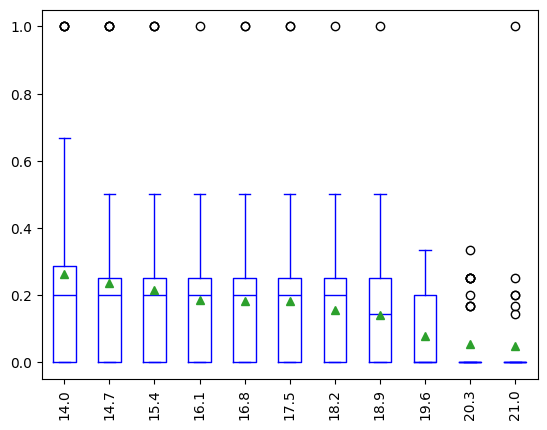

In [30]:
stats_count_df = naive_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].count().reset_index().merge(
    graph_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].count(),
    on = ["block_number", "log_u_eth_norm"],
    suffixes = ["_naive", "_graph"],
    how = "left"
).fillna(0).assign(
    eth_return_precost_ratio = lambda df: df["eth_return_precost_graph"].div(df["eth_return_precost_naive"])
)

ax = stats_count_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").fillna(0).boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])

[Text(1, 0, '14.0'),
 Text(2, 0, '14.7'),
 Text(3, 0, '15.4'),
 Text(4, 0, '16.1'),
 Text(5, 0, '16.8'),
 Text(6, 0, '17.5'),
 Text(7, 0, '18.2'),
 Text(8, 0, '18.9'),
 Text(9, 0, '19.6'),
 Text(10, 0, '20.3'),
 Text(11, 0, '21.0')]

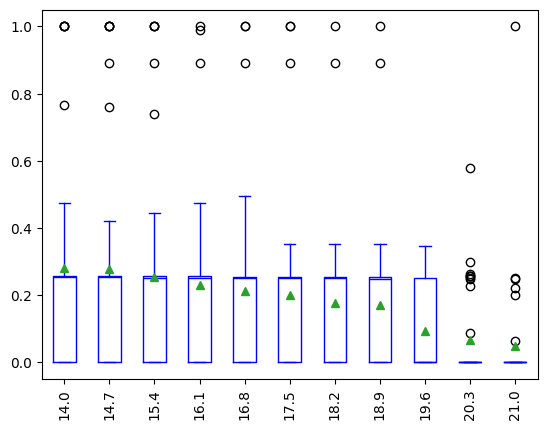

In [31]:
stats_sum_df = naive_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].sum().reset_index().merge(
    graph_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].sum(),
    on = ["block_number", "log_u_eth_norm"],
    suffixes = ["_naive", "_graph"],
    how = "left"
).fillna(0).assign(
    eth_return_precost_ratio = lambda df: df["eth_return_precost_graph"].div(df["eth_return_precost_naive"])
)
ax = stats_sum_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").fillna(0).boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])

[Text(1, 0, '14.0'),
 Text(2, 0, '14.7'),
 Text(3, 0, '15.4'),
 Text(4, 0, '16.1'),
 Text(5, 0, '16.8'),
 Text(6, 0, '17.5'),
 Text(7, 0, '18.2'),
 Text(8, 0, '18.9'),
 Text(9, 0, '19.6'),
 Text(10, 0, '20.3'),
 Text(11, 0, '21.0')]

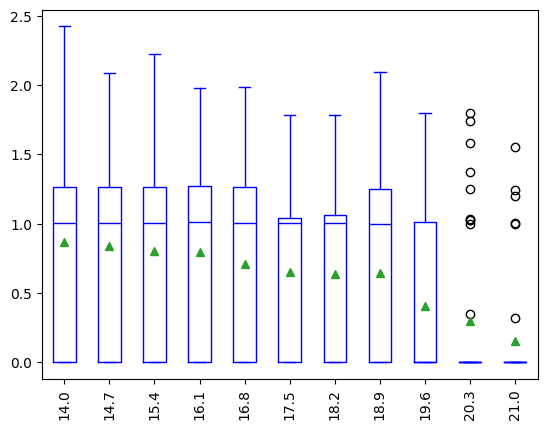

In [32]:
stats_mean_df = naive_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].mean().reset_index().merge(
    graph_df.groupby(["block_number", "log_u_eth_norm"])["eth_return_precost"].mean(),
    on = ["block_number", "log_u_eth_norm"],
    suffixes = ["_naive", "_graph"],
    how = "left"
).fillna(0).assign(
    eth_return_precost_ratio = lambda df: df["eth_return_precost_graph"].div(df["eth_return_precost_naive"])
)

ax = stats_mean_df.pivot(index = "block_number", columns = "log_u_eth_norm", values = "eth_return_precost_ratio").fillna(0).boxplot(color = "blue", rot = 90, grid = False, showmeans = True)
ax.set_xticklabels([round(float(x.get_text()), 1) for x in ax.get_xticklabels()])

<Axes: xlabel='block_number,log_u_eth_norm'>

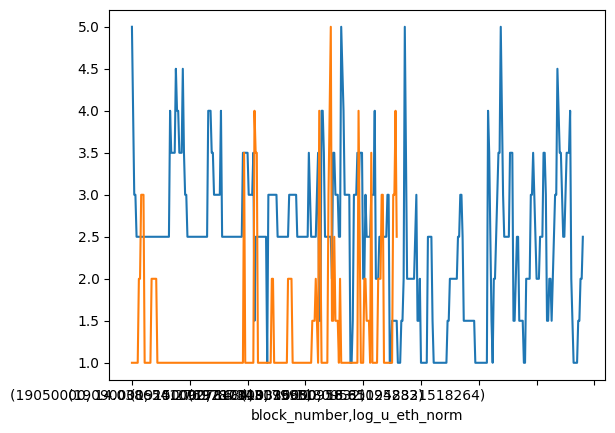

In [33]:
naive_arb_rank_df = naive_df.groupby(["block_number", "log_u_eth_norm"]).apply(
    lambda df: df.assign(
        arb_rank = lambda x: x["eth_return_precost"].rank(ascending = False)
    ).sort_values("arb_rank")
).reset_index(drop = True)
graph_arb_rank_df = graph_df.merge(
    naive_arb_rank_df,
    how = "left",
    on = COLUMNS_ID + ["log_u_eth_norm"],
    suffixes = ["_graph", "_naive"]
)

naive_arb_rank_df.groupby(["block_number", "log_u_eth_norm"])["arb_rank"].mean().plot()
graph_arb_rank_df.groupby(["block_number", "log_u_eth_norm"])["arb_rank"].mean().plot()

In [34]:
def create_hop_df(df: pd.DataFrame):
    hop_list = []
    for idx in range(len(df)):
        entry = df.iloc[idx].copy()
        for hop in entry["path"]:
            hop_list.append(
                {
                    "block_number": entry["block_number"],
                    "num_of_tokens": entry["num_of_tokens"],
                    "u_eth": entry["u_eth"],
                    "eth_return_precost": entry["eth_return_precost"],
                    "u_eth_norm": entry["u_eth_norm"],
                    "log_u_eth_norm": entry["log_u_eth_norm"],
                    "pool": hop["exchange_edge"]["exchange_function"]["swap_function"],
                    "path_length": len(entry["path"])
                }
            )
    return pd.DataFrame(hop_list)

In [35]:
naive_hop_df = create_hop_df(naive_df)
graph_hop_df = create_hop_df(graph_df)

<Axes: >

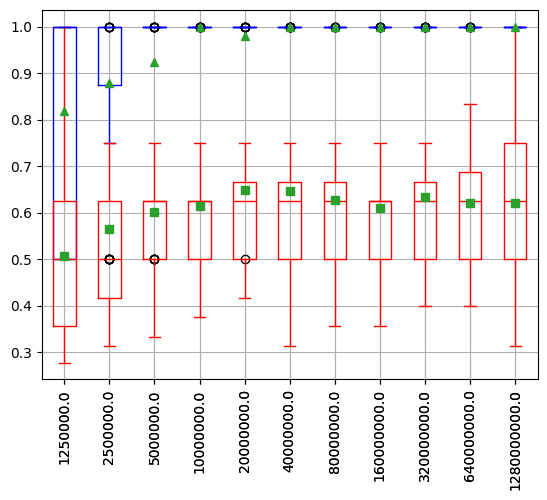

In [36]:
graph_hop_df.groupby(["block_number", "u_eth_norm"]).apply(
    lambda df: df["pool"].nunique() / df["pool"].count()
).rename("unique_pool_ratio").reset_index().pivot(
    index = "block_number", columns = "u_eth_norm", values = "unique_pool_ratio"
).boxplot(color = GRAPH_COLOR, showmeans = True, rot = 90)

naive_hop_df.groupby(["block_number", "u_eth_norm"]).apply(
    lambda df: df["pool"].nunique() / df["pool"].count()
).rename("unique_pool_ratio").reset_index().pivot(
    index = "block_number", columns = "u_eth_norm", values = "unique_pool_ratio"
).boxplot(color = NAIVE_COLOR, showmeans = True, rot = 90, meanprops={"marker":"s"})